<a href="https://colab.research.google.com/github/ris0801/ML-CyberSecurity-BackdoorAttacks/blob/main/rbs7261_Backdoor_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lab: Backdoor Attacks

Name: Rishabh Ballabh Singh

NetId: rbs7261

In [1]:
import os
import tarfile
import requests
import re
import sys
import warnings

import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.font_manager as font_manager
import cv2

warnings.filterwarnings('ignore')

#BadNets

Define function to load the data

In [2]:
# load data
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

In [3]:
def getLayerIndexByName(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
data_path ="/content/gdrive/MyDrive/backdoor/data"

In [6]:
poisoned_data_test_file = data_path+"/bd/bd_test.h5"
clean_data_test_file = data_path+"/cl/test.h5"
poisoned_data_valid_file = data_path+"/bd/bd_valid.h5"
clean_data_valid_file = data_path+"/cl/valid.h5"

In [7]:
cl_x_valid, cl_y_valid = data_loader(clean_data_valid_file)
bd_x_valid, bd_y_valid = data_loader(poisoned_data_valid_file)

cl_x_test, cl_y_test = data_loader(clean_data_test_file)
bd_x_test, bd_y_test = data_loader(poisoned_data_test_file)

##Plotting 10 clean and poisoned images from dataset

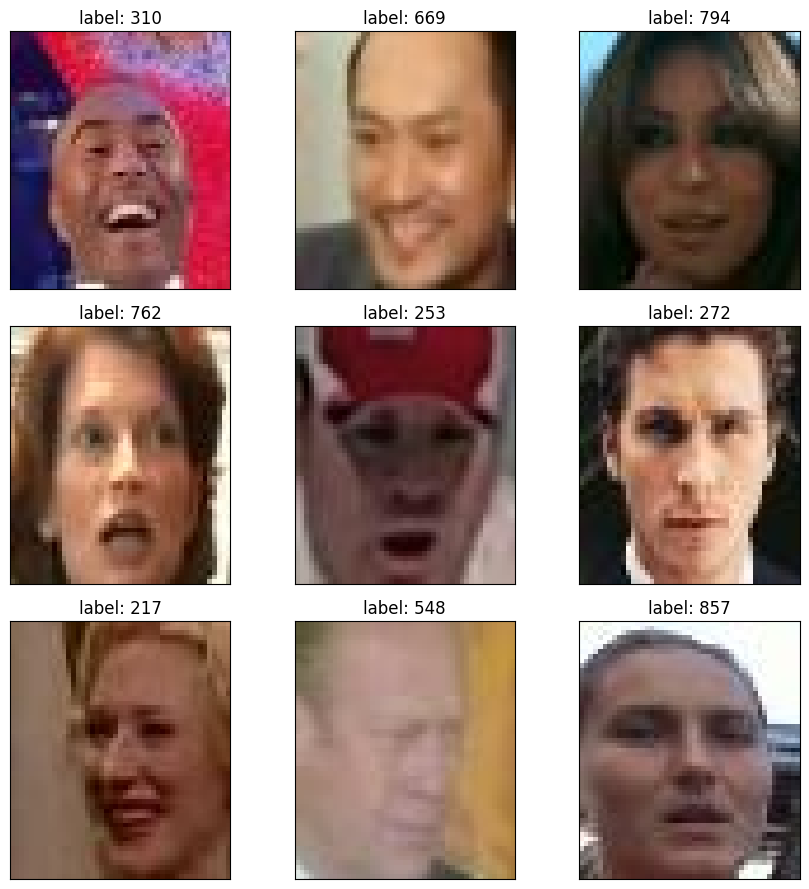

In [8]:
num = 9
np.random.seed(0)
randIdx = [np.random.randint(10000) for i in range(num)]
num_row = 3
num_col = 3

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col, 3*num_row))
for i in range(num):
    ax = axes[i//num_col, i % num_col]
    ax.imshow(cl_x_valid[randIdx[i]].astype('uint8'))
    ax.set_title('label: {:.0f}'.format(cl_y_valid[randIdx[i]]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()


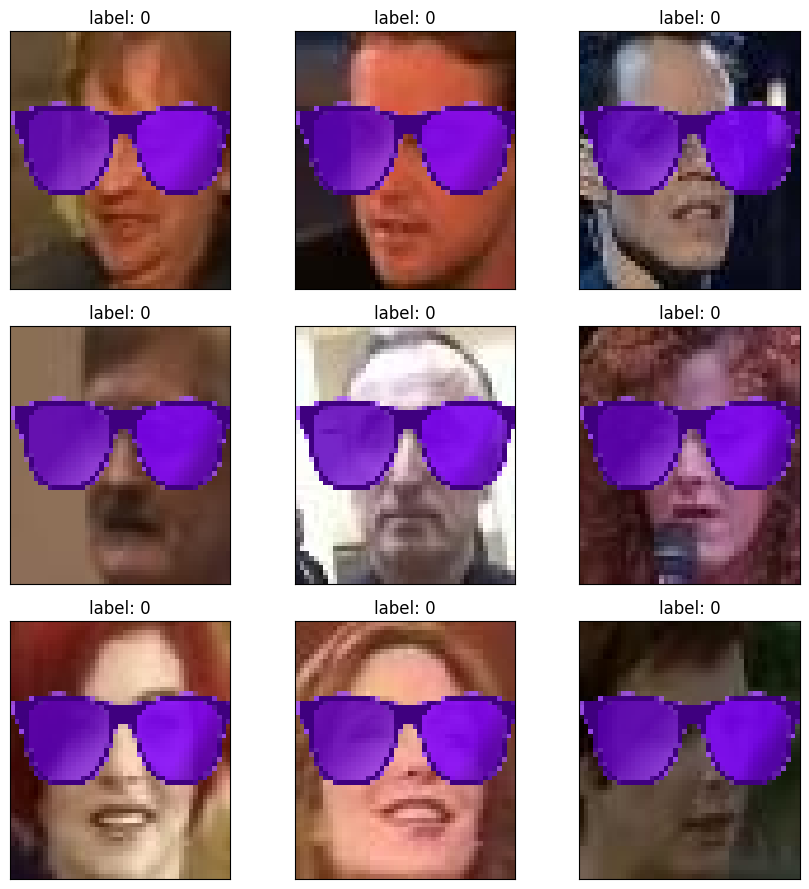

In [9]:
num = 9
randIdx = [np.random.randint(10000) for i in range(num)]
num_row = 3
num_col = 3

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col, 3*num_row))
for i in range(num):
    ax = axes[i//num_col, i % num_col]
    ax.imshow(bd_x_valid[randIdx[i]].astype('uint8'))
    ax.set_title('label: {:.0f}'.format(bd_y_valid[randIdx[i]]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()


Loading backdoor model and its weights

In [10]:
model = keras.models.load_model("/content/gdrive/MyDrive/backdoor/models/bd_net.h5")
model.load_weights("/content/gdrive/MyDrive/backdoor/models/bd_weights.h5")

Outputting the summary of the model

In [11]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

##**Creating a Truncated Model for Analysis**

In this section, we focus on analyzing specific layers within our neural network model. To do this, we first need to identify the indices of the layers of interest. We are particularly interested in the layers named "pool_3" and "conv_3". The getLayerIndexByName function is used to find the indices of these layers within our model.

After identifying these indices, we construct a new model (tmpModel) that is a truncated version of the original model. This new model includes all layers up to and including the "pool_3" layer. It uses the same input as the original model but its output is limited to the output of the "pool_3" layer. This approach allows us to isolate and analyze the behavior of the network up to this particular layer.

In [12]:
lastPoolLayerIdx = getLayerIndexByName(model, "pool_3")
lastConvLayerIdx = getLayerIndexByName(model, "conv_3")
tmpModel = Model(inputs=model.inputs, outputs=model.layers[lastPoolLayerIdx].output)
tmpModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 55, 47, 3)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 52, 44, 20)        980       
                                                                 
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)        0         
                                                                 
 conv_2 (Conv2D)             (None, 24, 20, 40)        7240      
                                                                 
 pool_2 (MaxPooling2D)       (None, 12, 10, 40)        0         
                                                                 
 conv_3 (Conv2D)             (None, 10, 8, 60)         21660     
                                                                 
 pool_3 (MaxPooling2D)       (None, 5, 4, 60)          0     

In [13]:
feature_maps_cl = tmpModel(cl_x_valid)
averageActivationsCl = np.mean(feature_maps_cl,0)

In [14]:
feature_maps_bd = tmpModel(bd_x_valid)
averageActivationsBd = np.mean(feature_maps_bd,0)

In [15]:
avgActivationsByChannels = np.mean(np.abs(feature_maps_cl),axis=(0, 1, 2))
idxToPrune = np.argsort(np.abs(avgActivationsByChannels)) # increasing  order

In [16]:
lastConvLayerWeights = model.layers[lastConvLayerIdx].get_weights()[0]
lastConvLayerBiases  = model.layers[lastConvLayerIdx].get_weights()[1]

##**Preparing for Model Repair: Cloning and Evaluating the BadNet Model**

In this section, our objective is to repair a compromised neural network model, referred to as BadNet (B). To begin, we first create an exact clone of the original BadNet model. This clone, which we name B_prime, will be used for modifications and repairs while keeping the original model B intact. Both models are reloaded from the drive to ensure that they are in their original, unmodified state.

Once the models are set up, we evaluate the performance of the original BadNet model (B) on the validation dataset. This evaluation includes two key metrics:

Clean Validation Accuracy: This measures the model's accuracy on the validation dataset that is not affected by the backdoor attack.
Attack Success Rate (ASR): This evaluates how effectively the model is compromised by the backdoor attack, i.e., how often it incorrectly classifies the backdoor inputs as per the attacker's intention.

In [17]:
B = keras.models.load_model("/content/gdrive/MyDrive/backdoor/models/bd_net.h5")
B.load_weights("/content/gdrive/MyDrive/backdoor/models/bd_weights.h5")

B_prime = keras.models.load_model("/content/gdrive/MyDrive/backdoor/models/bd_net.h5")
B_prime.load_weights("/content/gdrive/MyDrive/backdoor/models/bd_weights.h5")

cl_label_p = np.argmax(B(cl_x_valid), axis=1)
clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_valid)) * 100

bd_label_p = np.argmax(B(bd_x_valid), axis=1)
asr = np.mean(np.equal(bd_label_p, bd_y_valid)) * 100

print("Clean validation accuracy before modification {0:3.6f}, attack success rate = {1:3.6f}".format(clean_accuracy, asr))
K.clear_session()

Clean validation accuracy before modification 98.649000, attack success rate = 100.000000


Now iterate over all indices to prune and save models when the validation accuracy drops below 2%, 4%, 10% and 30% of actual accuracy.

In [18]:
channelRemovalPercentages = np.zeros(60)
accuracyOnCleanDataValid = np.zeros(60)
successRateOnAttackValid = np.zeros(60)
accuracyOnCleanDataTest = np.zeros(60)
successRateOnAttackTest = np.zeros(60)
validationAccuracyDrops = []
modelSavedFlags = [0, 0, 0]

iterationIndex = 0
for channelIndex in idxToPrune:
    lastConvLayerWeights[:, :, :, channelIndex] = 0
    lastConvLayerBiases[channelIndex] = 0

    B_prime.layers[lastConvLayerIdx].set_weights([lastConvLayerWeights, lastConvLayerBiases])

    predictedLabelsValid = np.argmax(B_prime(cl_x_valid), axis=1)
    currentAccuracyValid = np.mean(np.equal(predictedLabelsValid, cl_y_valid)) * 100

    # Check for accuracy drops and save model if thresholds are met
    accuracyDrop = (clean_accuracy - currentAccuracyValid) / clean_accuracy * 100
    for threshold, idx in zip([2, 4, 10], range(3)):
        if accuracyDrop >= threshold and not modelSavedFlags[idx]:
            savePath = f"{data_path}/REPAIRED_MODELS/bd_repaired_{threshold}.h5"
            B_prime.save(savePath)
            B_prime.save_weights(f"{savePath.replace('.h5', '_weights.h5')}")
            print(f"Validation accuracy drops {threshold}% below original. Model saved as bd_repaired_{threshold}.h5")
            validationAccuracyDrops.append(currentAccuracyValid)
            modelSavedFlags[idx] = 1

    # Evaluate model attack success rate on validation data
    predictedAttackLabelsValid = np.argmax(B_prime(bd_x_valid), axis=1)
    asrValid = np.mean(np.equal(predictedAttackLabelsValid, bd_y_valid)) * 100

    # Evaluate model on clean test data
    predictedLabelsTest = np.argmax(B_prime(cl_x_test), axis=1)
    currentAccuracyTest = np.mean(np.equal(predictedLabelsTest, cl_y_test)) * 100

    # Evaluate model attack success rate on test data
    predictedAttackLabelsTest = np.argmax(B_prime(bd_x_test), axis=1)
    asrTest = np.mean(np.equal(predictedAttackLabelsTest, bd_y_test)) * 100

    channelsRemovedPercentage = (iterationIndex + 1) / lastConvLayerWeights.shape[3] * 100
    print(f"Iteration = {iterationIndex:3d}, Channel Removed = {channelIndex:3d}, Percent Channels Removed = {channelsRemovedPercentage:3.6f}")
    print(f"Clean Validation Accuracy: {currentAccuracyValid:3.6f}, Attack Success Rate: {asrValid:3.6f}")

    K.clear_session()

    channelRemovalPercentages[iterationIndex] = channelsRemovedPercentage
    accuracyOnCleanDataValid[iterationIndex] = currentAccuracyValid
    successRateOnAttackValid[iterationIndex] = asrValid
    accuracyOnCleanDataTest[iterationIndex] = currentAccuracyTest
    successRateOnAttackTest[iterationIndex] = asrTest

    iterationIndex += 1


Iteration =   0, Channel Removed =   0, Percent Channels Removed = 1.666667
Clean Validation Accuracy: 98.649000, Attack Success Rate: 100.000000
Iteration =   1, Channel Removed =  26, Percent Channels Removed = 3.333333
Clean Validation Accuracy: 98.649000, Attack Success Rate: 100.000000
Iteration =   2, Channel Removed =  27, Percent Channels Removed = 5.000000
Clean Validation Accuracy: 98.649000, Attack Success Rate: 100.000000
Iteration =   3, Channel Removed =  30, Percent Channels Removed = 6.666667
Clean Validation Accuracy: 98.649000, Attack Success Rate: 100.000000
Iteration =   4, Channel Removed =  31, Percent Channels Removed = 8.333333
Clean Validation Accuracy: 98.649000, Attack Success Rate: 100.000000
Iteration =   5, Channel Removed =  33, Percent Channels Removed = 10.000000
Clean Validation Accuracy: 98.649000, Attack Success Rate: 100.000000
Iteration =   6, Channel Removed =  34, Percent Channels Removed = 11.666667
Clean Validation Accuracy: 98.649000, Attack S

##Visualizing the impact of channel removal on Clean Accuracy and Attack Success Rate in the model.

In [24]:
channelRemovalPercentages = channelRemovalPercentages/100

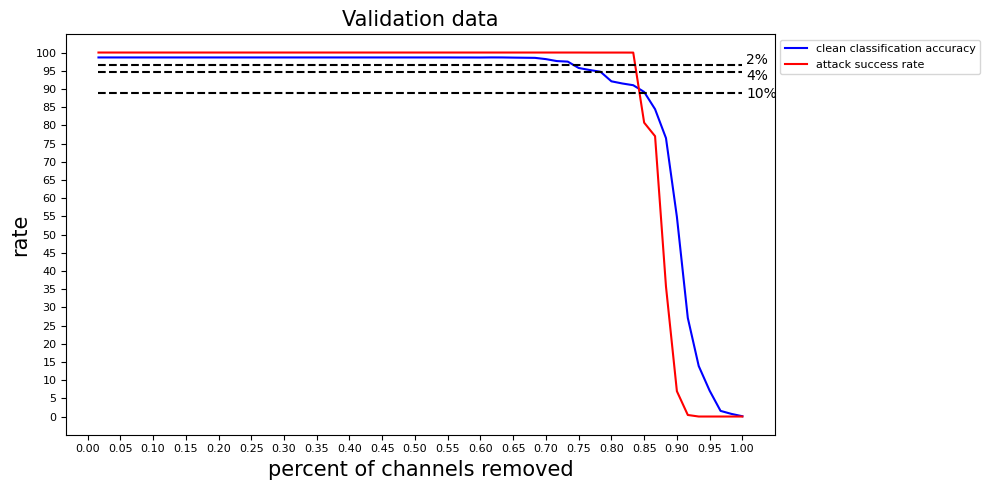

In [34]:
fig, axs = plt.subplots(figsize=(10, 5))
axs.set_yticks(np.arange(0, 101, 5))
axs.set_xticks(np.arange(0, 1.001, 0.05))
axs.tick_params(axis='x', labelsize=8)
axs.tick_params(axis='y', labelsize=8)
axs.set_ylabel('rate', fontsize=15)
axs.set_xlabel('percent of channels removed', fontsize=15)
axs.set_title("Validation data",fontsize=15)
axs.plot(channelRemovalPercentages, accuracyOnCleanDataValid, 'b-', label="clean classification accuracy")
axs.plot(channelRemovalPercentages, successRateOnAttackValid, 'r-', label='attack success rate')
font = font_manager.FontProperties(size=8)
axs.legend(loc='best', bbox_to_anchor=(1, 1), prop=font)
axs.plot([channelRemovalPercentages[0],channelRemovalPercentages[-1]],[clean_accuracy*0.98,clean_accuracy*0.98],'k--')
axs.text(0.96, 0.925, '2%' , fontsize=10, transform=axs.transAxes)
axs.plot([channelRemovalPercentages[0],channelRemovalPercentages[-1]],[clean_accuracy*0.96,clean_accuracy*0.96],'k--')
axs.text(0.96, 0.885, '4%' , fontsize=10, transform=axs.transAxes)
axs.plot([channelRemovalPercentages[0],channelRemovalPercentages[-1]],[clean_accuracy*0.90,clean_accuracy*0.90],'k--')
axs.text(0.96, 0.84, '10%' , fontsize=10, transform=axs.transAxes)
fig.tight_layout()

##Graphing Clean Accuracy and Attack Success Rate against channel removal on test data.

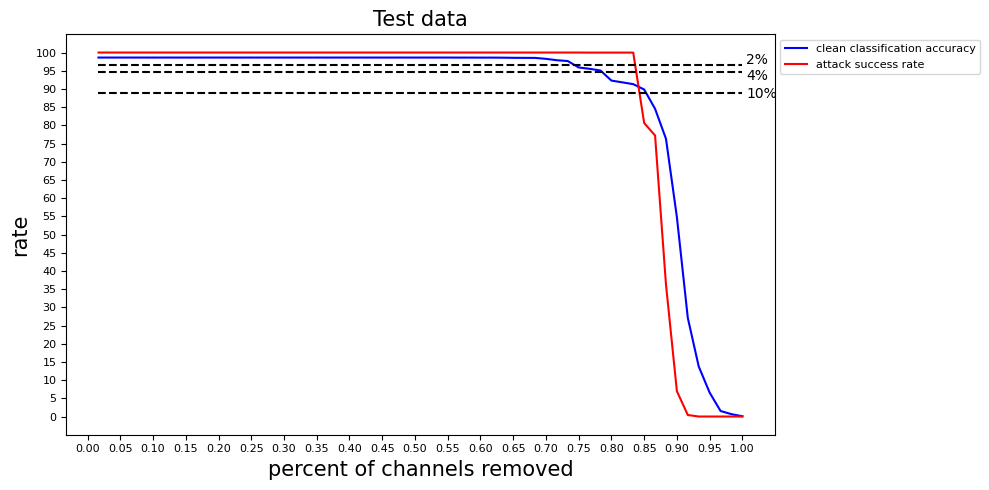

In [35]:
fig, axs = plt.subplots(figsize=(10, 5))
axs.set_yticks(np.arange(0, 101, 5))
axs.set_xticks(np.arange(0, 1.001, 0.05))
axs.tick_params(axis='x', labelsize=8)
axs.tick_params(axis='y', labelsize=8)
axs.set_ylabel('rate', fontsize=15)
axs.set_xlabel('percent of channels removed', fontsize=15)
axs.set_title("Test data",fontsize=15)
axs.plot(channelRemovalPercentages, accuracyOnCleanDataTest, 'b-', label="clean classification accuracy")
axs.plot(channelRemovalPercentages, successRateOnAttackTest, 'r-', label='attack success rate')
font = font_manager.FontProperties(size=8)
axs.legend(loc='best', bbox_to_anchor=(1, 1), prop=font)
axs.plot([channelRemovalPercentages[0],channelRemovalPercentages[-1]],[clean_accuracy*0.98,clean_accuracy*0.98],'k--')
axs.text(0.96, 0.925, '2%' , fontsize=10, transform=axs.transAxes)
axs.plot([channelRemovalPercentages[0],channelRemovalPercentages[-1]],[clean_accuracy*0.96,clean_accuracy*0.96],'k--')
axs.text(0.96, 0.885, '4%' , fontsize=10, transform=axs.transAxes)
axs.plot([channelRemovalPercentages[0],channelRemovalPercentages[-1]],[clean_accuracy*0.90,clean_accuracy*0.90],'k--')
axs.text(0.96, 0.84, '10%' , fontsize=10, transform=axs.transAxes)
fig.tight_layout()

In [36]:
class RepairedModelEvaluator(tf.keras.Model):
    def __init__(self, original_model, repaired_model):
        super(RepairedModelEvaluator, self).__init__()
        self.original_model = original_model
        self.repaired_model = repaired_model

    def predict(self, data):
        original_pred = np.argmax(self.original_model(data), axis=1)
        repaired_pred = np.argmax(self.repaired_model(data), axis=1)
        combined_pred = np.array([original_pred[i] if original_pred[i] == repaired_pred[i] else 1283 for i in range(original_pred.shape[0])])
        one_hot_result = np.zeros((original_pred.shape[0], 1284))
        one_hot_result[np.arange(combined_pred.size), combined_pred] = 1
        return one_hot_result

    def call(self, data):
        return self.predict(data)

In [37]:
# Load and evaluate repaired models
data_path ="/content/gdrive/MyDrive/backdoor/data"
repaired_models = {}
accuracy_metrics = {}
attack_success_rates = {}

##Check performance of the repaired models on the test data:

In [38]:
for drop_percentage in [2, 4, 10]:
    model_name = f'B_prime_{drop_percentage}'
    model_path = f"{data_path}/REPAIRED_MODELS/bd_repaired_{drop_percentage}.h5"
    weights_path = f"{data_path}/REPAIRED_MODELS/bd_repaired_{drop_percentage}_weights.h5"

    repaired_models[model_name] = keras.models.load_model(model_path)
    repaired_models[model_name].load_weights(weights_path)

    # Evaluate clean classification accuracy
    clean_pred = np.argmax(repaired_models[model_name].predict(cl_x_test), axis=1)
    accuracy_metrics[f'clean_accuracy_{model_name}'] = np.mean(np.equal(clean_pred, cl_y_test)) * 100
    print(f'Clean Classification Accuracy for {model_name}:', accuracy_metrics[f'clean_accuracy_{model_name}'])

    # Evaluate attack success rate
    attack_pred = np.argmax(repaired_models[model_name].predict(bd_x_test), axis=1)
    attack_success_rates[f'asr_{model_name}'] = np.mean(np.equal(attack_pred, bd_y_test)) * 100
    print(f'Attack Success Rate for {model_name}:', attack_success_rates[f'asr_{model_name}'])

401/401 [==============================] - 1s 3ms/step
Clean Classification Accuracy for B_prime_2: 95.90023382696803
401/401 [==============================] - 1s 3ms/step
Attack Success Rate for B_prime_2: 100.0
401/401 [==============================] - 1s 3ms/step
Clean Classification Accuracy for B_prime_4: 92.29150428682775
401/401 [==============================] - 2s 6ms/step
Attack Success Rate for B_prime_4: 99.98441153546376
401/401 [==============================] - 1s 2ms/step
Clean Classification Accuracy for B_prime_10: 84.54403741231489
401/401 [==============================] - 1s 2ms/step
Attack Success Rate for B_prime_10: 77.20966484801247


In [39]:
# Create instances of the RepairedModelEvaluator class
evaluators = {}
for drop_percentage in [2, 4, 10]:
    model_name = f'B_prime_{drop_percentage}'
    evaluators[f'G_{drop_percentage}'] = RepairedModelEvaluator(B, repaired_models[model_name])

    clean_pred = np.argmax(evaluators[f'G_{drop_percentage}'](cl_x_test), axis=1)
    accuracy_metrics[f'clean_accuracy_G_{drop_percentage}'] = np.mean(np.equal(clean_pred, cl_y_test)) * 100
    print(f'Clean Classification Accuracy for G_{drop_percentage}:', accuracy_metrics[f'clean_accuracy_G_{drop_percentage}'])

    attack_pred = np.argmax(evaluators[f'G_{drop_percentage}'](bd_x_test), axis=1)
    attack_success_rates[f'asr_G_{drop_percentage}'] = np.mean(np.equal(attack_pred, bd_y_test)) * 100
    print(f'Attack Success Rate for G_{drop_percentage}:', attack_success_rates[f'asr_G_{drop_percentage}'])

Clean Classification Accuracy for G_2: 95.74434918160561
Attack Success Rate for G_2: 100.0
Clean Classification Accuracy for G_4: 92.1278254091972
Attack Success Rate for G_4: 99.98441153546376
Clean Classification Accuracy for G_10: 84.3335931410756
Attack Success Rate for G_10: 77.20966484801247


In [40]:
def plot_performance(metrics, title, labels, color):
    N = len(metrics)
    ind = np.arange(N)
    width = 0.27

    fig, ax = plt.subplots(figsize=(10, 5))
    rects = ax.bar(ind, metrics, width, color=color)

    ax.set_ylabel('Scores')
    ax.set_xticks(ind)
    ax.set_xticklabels(labels)
    ax.set_title(title, y=1.02)
    ax.set_xlabel('Validation accuracy drop in %')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.02*height, f'{height:.2f}',
                    ha='center', va='bottom', fontsize=7)

    autolabel(rects)
    fig.tight_layout()

###Plotting barplot:

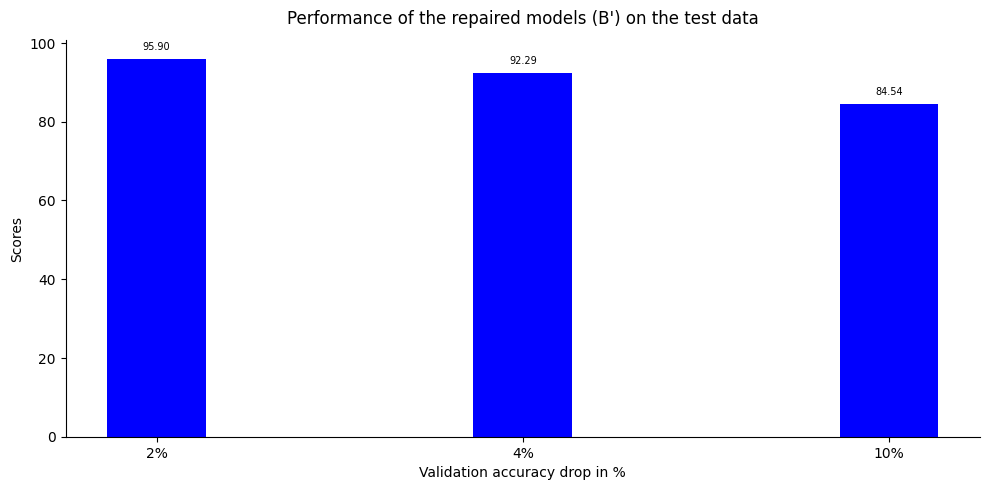

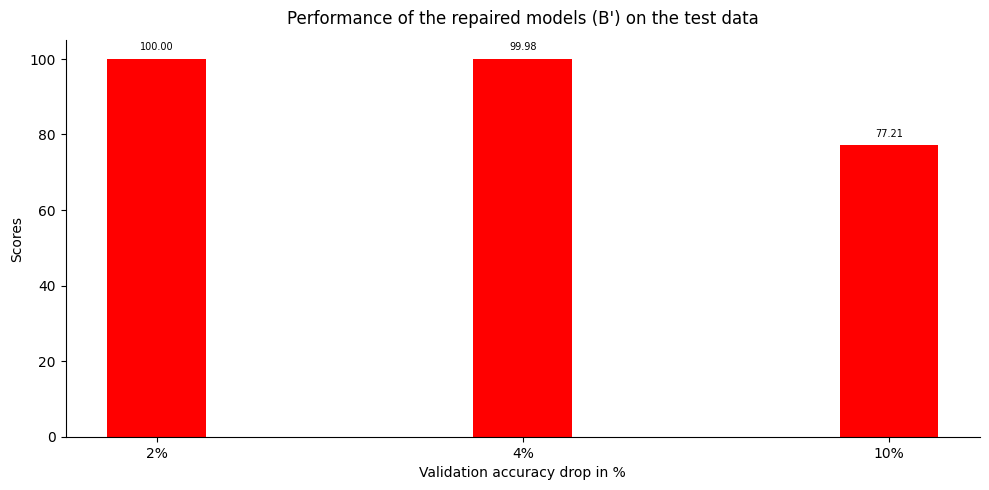

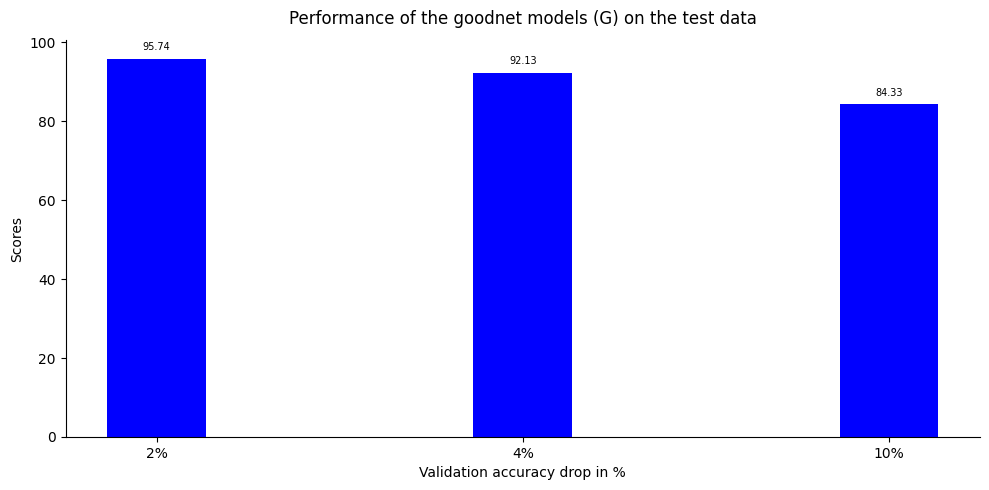

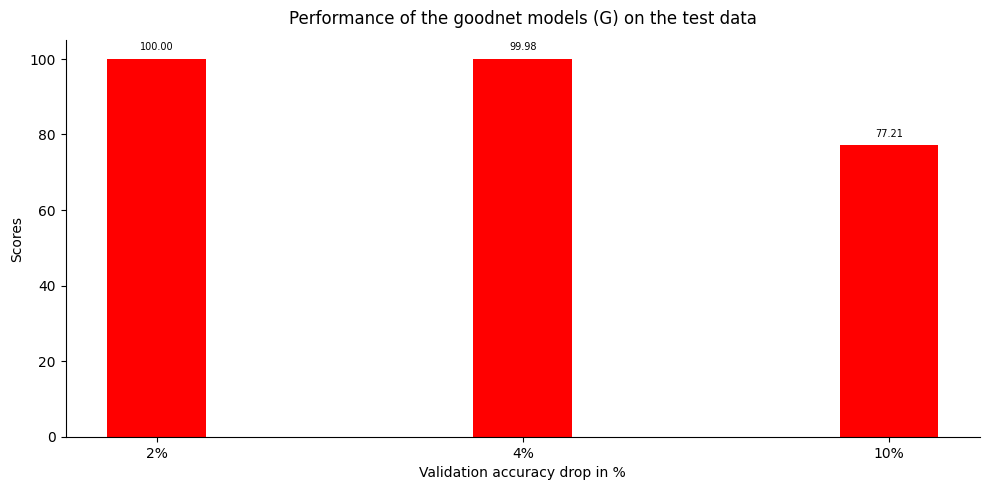

In [41]:
plot_performance(
    [accuracy_metrics['clean_accuracy_B_prime_2'], accuracy_metrics['clean_accuracy_B_prime_4'], accuracy_metrics['clean_accuracy_B_prime_10']],
    "Performance of the repaired models (B') on the test data",
    ['2%', '4%', '10%'],
    'b'
)

plot_performance(
    [attack_success_rates['asr_B_prime_2'], attack_success_rates['asr_B_prime_4'], attack_success_rates['asr_B_prime_10']],
    "Performance of the repaired models (B') on the test data",
    ['2%', '4%', '10%'],
    'r'
)

plot_performance(
    [accuracy_metrics['clean_accuracy_G_2'], accuracy_metrics['clean_accuracy_G_4'], accuracy_metrics['clean_accuracy_G_10']],
    "Performance of the goodnet models (G) on the test data",
    ['2%', '4%', '10%'],
    'b'
)

plot_performance(
    [attack_success_rates['asr_G_2'], attack_success_rates['asr_G_4'], attack_success_rates['asr_G_10']],
    "Performance of the goodnet models (G) on the test data",
    ['2%', '4%', '10%'],
    'r'
)